In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.plot_helpers import *
from helpers.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import hvplot
hvplot.output(widget_location='bottom')

# Snapshot

In [2]:
def e_to_h(e, h):
    thickness = h * 0
    
    for zl in range(len(h.zl)):
        thickness[{'zl':zl}] = e.isel(zi=zl)-e.isel(zi=zl+1)
    
    return thickness

In [3]:
R32f_one_degree = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/1-degree-snapshots.nc', decode_times=False).isel(time=-1)
R32f_half_degree = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/0.5-degree-snapshots.nc', decode_times=False).isel(time=-1)
R4 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/snapshots_00029010.nc', decode_times=False).isel(time=-1)
R4_smooth_weak = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-filter-3D/output/snapshots_00029010.nc', decode_times=False).isel(time=-1)
R4_reynolds_weak = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Reynolds-newest-code/output/snapshots_00029010.nc', decode_times=False).isel(time=-1)
R4_smooth_strong = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-3.0/output/snapshots_00029010.nc', decode_times=False).isel(time=-1)
R4_reynolds_strong = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Reynolds-3.0/output/snapshots_00029010.nc', decode_times=False).isel(time=-1)
R4_jh = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/JansenHeld-Cs-0.2-Cback-0.1/output/snapshots_00029010.nc', decode_times=False).isel(time=-1)
R4_yankovsky_strong = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Yankovsky23/output/snapshots_00029010.nc', decode_times=False).isel(time=-1)
R4_yankovsky_weak = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Yankovsky23-0.3/output/snapshots_00029010.nc', decode_times=False).isel(time=-1)

In [4]:
R32f_half_degree['h'] = e_to_h(R32f_half_degree.e, R32f_half_degree.h)
R32f_one_degree['h'] = e_to_h(R32f_one_degree.e, R32f_one_degree.h)

In [5]:
def KEz(ds):
    return 0.5 * (ds.h * (remesh(ds.u**2, ds.h) + remesh(ds.v**2, ds.h))).sum('zl')

subsample
Colorbar-like object skipped


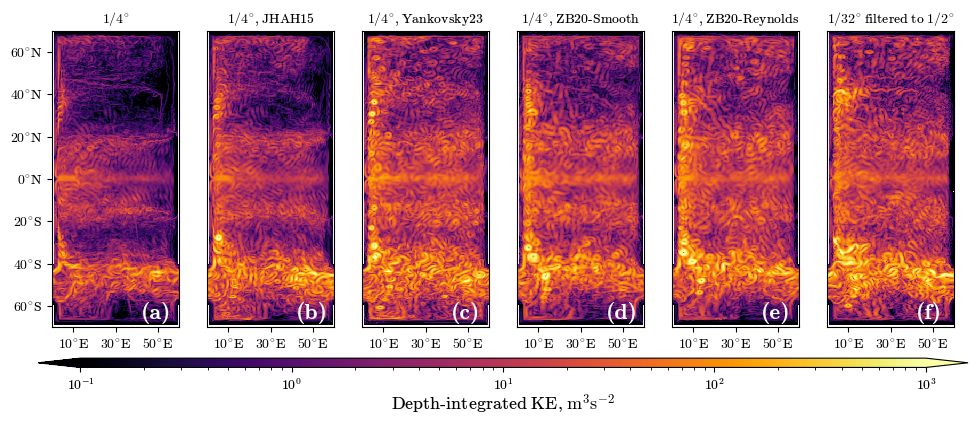

In [15]:
import matplotlib as mpl

default_rcParams({'figure.subplot.wspace': 0.0, 'figure.subplot.hspace': 0.3, 'font.size': 10})

plt.figure(figsize=(12,5))
for col, (exp, label) in enumerate(
    zip(
    [R4, R4_jh, R4_yankovsky_strong, R4_smooth_strong, R4_reynolds_strong, R32f_half_degree],
    ['$1/4^{\circ}$', '$1/4^{\circ}$, JHAH15', '$1/4^{\circ}$, Yankovsky23', '$1/4^{\circ}$, ZB20-Smooth', '$1/4^{\circ}$, ZB20-Reynolds', '$1/32^{\circ}$ filtered to $1/2^{\circ}$']
    )):
    plt.subplot(1,6,col+1)
    KE = KEz(exp)
    if col==5:
        print('subsample')
        KE = KE.isel(xh=slice(None,None,8), yh=slice(None,None,8))
    im = KE.plot.imshow(
        norm=mpl.colors.LogNorm(vmin=1e-1, vmax=1e+3),
        cmap='inferno',
        add_colorbar=False,
        interpolation='none'
    )
    plt.gca().axes.set_aspect('equal')
    plt.xlabel('')
    plt.ylabel('')
    plt.title(label, fontsize=10)
    lons = [10,30,50]
    plt.xticks(lons, [f'${lon}^'+'{\circ}$E' for lon in lons])
    if col==0:
        lats = [-60, -40, -20, 0, 20, 40, 60]
        lat_ticks = [f'${-lat}^'+'{\circ}$S' if lat<0 else f'${lat}^'+'{\circ}$N' for lat in lats]
        plt.yticks(lats, lat_ticks)
    else:
        plt.yticks([])
        
plt.colorbar(im, pad=0.08, aspect=100, orientation='horizontal', ax=plt.gcf().axes, extend='both').set_label(fontsize=13, label='Depth-integrated KE, $\mathrm{m}^3 \mathrm{s}^{-2}$')
set_letters(x=0.7, y=0.03, fontsize=15, color='white')
plt.savefig('Review-2/snapshot-strong.pdf')

subsample
Colorbar-like object skipped


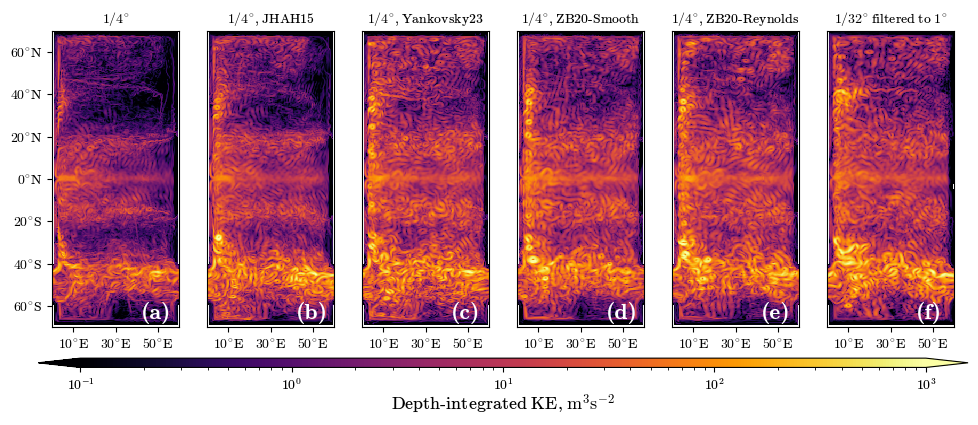

In [16]:
import matplotlib as mpl

default_rcParams({'figure.subplot.wspace': 0.0, 'figure.subplot.hspace': 0.3, 'font.size': 10})

plt.figure(figsize=(12,5))
for col, (exp, label) in enumerate(
    zip(
    [R4, R4_jh, R4_yankovsky_weak, R4_smooth_weak, R4_reynolds_weak, R32f_one_degree],
    ['$1/4^{\circ}$', '$1/4^{\circ}$, JHAH15', '$1/4^{\circ}$, Yankovsky23', '$1/4^{\circ}$, ZB20-Smooth', '$1/4^{\circ}$, ZB20-Reynolds', '$1/32^{\circ}$ filtered to $1^{\circ}$']
    )):
    plt.subplot(1,6,col+1)
    KE = KEz(exp)
    if col==5:
        print('subsample')
        KE = KE.isel(xh=slice(None,None,8), yh=slice(None,None,8))
    im = KE.plot.imshow(
        norm=mpl.colors.LogNorm(vmin=1e-1, vmax=1e+3),
        cmap='inferno',
        add_colorbar=False,
        interpolation='none'
    )
    plt.gca().axes.set_aspect('equal')
    plt.xlabel('')
    plt.ylabel('')
    plt.title(label, fontsize=10)
    lons = [10,30,50]
    plt.xticks(lons, [f'${lon}^'+'{\circ}$E' for lon in lons])
    if col==0:
        lats = [-60, -40, -20, 0, 20, 40, 60]
        lat_ticks = [f'${-lat}^'+'{\circ}$S' if lat<0 else f'${lat}^'+'{\circ}$N' for lat in lats]
        plt.yticks(lats, lat_ticks)
    else:
        plt.yticks([])
        
plt.colorbar(im, pad=0.08, aspect=100, orientation='horizontal', ax=plt.gcf().axes, extend='both').set_label(fontsize=13, label='Depth-integrated KE, $\mathrm{m}^3 \mathrm{s}^{-2}$')
set_letters(x=0.7, y=0.03, fontsize=15, color='white')
plt.savefig('Review-2/snapshot-weak.pdf')

subsample
Colorbar-like object skipped


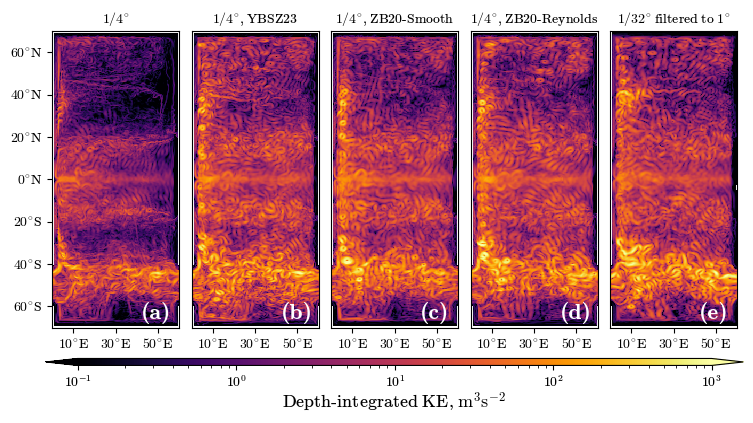

In [6]:
import matplotlib as mpl

default_rcParams({'figure.subplot.wspace': 0.0, 'figure.subplot.hspace': 0.3, 'font.size': 10})

plt.figure(figsize=(9,5))
for col, (exp, label) in enumerate(
    zip(
    [R4, R4_yankovsky_weak, R4_smooth_weak, R4_reynolds_weak, R32f_one_degree],
    ['$1/4^{\circ}$', '$1/4^{\circ}$, YBSZ23', '$1/4^{\circ}$, ZB20-Smooth', '$1/4^{\circ}$, ZB20-Reynolds', '$1/32^{\circ}$ filtered to $1^{\circ}$']
    )):
    plt.subplot(1,5,col+1)
    KE = KEz(exp)
    if col==4:
        print('subsample')
        KE = KE.isel(xh=slice(None,None,8), yh=slice(None,None,8))
    im = KE.plot.imshow(
        norm=mpl.colors.LogNorm(vmin=1e-1, vmax=1e+3),
        cmap='inferno',
        add_colorbar=False,
        interpolation='none'
    )
    plt.gca().axes.set_aspect('equal')
    plt.xlabel('')
    plt.ylabel('')
    plt.title(label, fontsize=10)
    lons = [10,30,50]
    plt.xticks(lons, [f'${lon}^'+'{\circ}$E' for lon in lons])
    if col==0:
        lats = [-60, -40, -20, 0, 20, 40, 60]
        lat_ticks = [f'${-lat}^'+'{\circ}$S' if lat<0 else f'${lat}^'+'{\circ}$N' for lat in lats]
        plt.yticks(lats, lat_ticks)
    else:
        plt.yticks([])
        
plt.colorbar(im, pad=0.08, aspect=100, orientation='horizontal', ax=plt.gcf().axes, extend='both').set_label(fontsize=13, label='Depth-integrated KE, $\mathrm{m}^3 \mathrm{s}^{-2}$')
set_letters(x=0.7, y=0.03, fontsize=15, color='white')
plt.savefig('Review-2/Figure-snapshot.pdf')